## R(t)

Calculo el radio en función del tiempo usando la ecuación 2.2.1.1 de la tesis de Gabriela  
1. A través del cambio de variables R = R, v_R = R', transformo la ecuación diferencial de orden 2 en dos ecuaciones diferenciales de orden 1
2. Me armo el sistema dy/dt = f(y,t) donde y = (R, v_R) y resuelvo la ecuación numéricamente
(El desarrollo de las ecuaciones está en el cuadernillo)

Comentarios:  
* La dependencia de la presión de la burbuja p_B está dada por la presión eléctrica p_e del paper de Bunkin
* La dependencia de la masa m(t) se asume conocida pero realmente habría que estimarla usando el problema de reacciones + condensación o, mejor dicho, resolviendo todo autoconsistentemente.
* Las fórmulas del paper están en el sistema CGS, así que expreso todo en esas unidades

DUDAS:
* Estoy considerando rho_L_inf = rho_L_i, está bien?
* Estoy tomando x_max = 6 (aproximación del paper antes de la ec. (18)), está bien?
* rho_Bunkin = rho_L_inf  o rho_L_i ? Estoy considerando a priori lo primero, está bien?
* u0 (mu) da igual que a lo que da la ec. 19a (19b)? Sí, da lo mismo. u0 da ligeramente distinto pero creo que puede deberse a que estoy tomando una densidad distinta.
* Estoy asumiendo que las ecuaciones de Bunkin están en el sistema MKS y por lo tanto los parámetros del problema están en MKS
* Verificar si T_e = Delta/3 siempre o cambia durante la evolución
* R0 = 1e-6 
* v_R0 = 0? condición inicial
* En la solución numérica se asumió que el problema no es stiff
* a_i = 2e-5 para nuestro problema? radio del electrolito
* l = 2*a_i #aproximación hecha en el Bunkin

In [175]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from math import pi

### Parámetros del problema

In [176]:
#En CGS:
#Parámetros de la ecuación diferencial
p_inf = 0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
c_L = 1415.1 #velocidad del sonido del líquido en [m/s] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela.
c_L = c_L*100 #en [cm/s] (CGS). Conversión (m/s)*(100 cm/m)
rho_L_i = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L_i = rho_L_i*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)
rho_L_inf = rho_L_i #densidad del líquido en el infinito. A priori considero rho_L_inf = rho_L_i

#Parámetros de la presión eléctrica p_e

#En CGS:
#Condiciones iniciales de la ecuación diferencial
Delta = 6 #Energía mecánica para arrancar un electrón de la pared en [eV]
T_e = Delta/3 #Temperatura de los electrones dentro de la burbuja en [eV]. Conversión: (ev)*()
T_e = T_e*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)
x_max = 6 #Esto es una aproximación considerada en el paper antes de la ec. (18)
q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

R0 = 1e-6 #Radio inicial de un bubston en [cm]. Este valor lo saqué del supuesto inicial del Bunkin

n_e_max_mean = (16/3)*T_e**2/(pi*q_e**4*R0) #densidad media máxima
rho_Bunkin = rho_L_inf #densidad del líquido
u0 = np.sqrt( (2*x_max/9)*n_e_max_mean*T_e/rho_Bunkin ) #Calculo u0 a partir de expresión (19a) del paper de Bunkin
mu = (8/(3*x_max))*((x_max-1)/x_max)**2*(T_e*R0/q_e**2) #Calculo mu a partir de expresión (19b) del paper de Bunkin

In [177]:
#Verifico si obtengo los mismos valores
print("n_e_max_mean = ", n_e_max_mean)
print("u0 = ", u0)
print("mu = ", mu)

n_e_max_mean =  3.278883224283173e+20
u0 =  35657.52082504035
mu =  4.289370267350276


### Funciones de presión y masa

In [178]:
#Defino funciones de presión

def p_B(R):
    #Presión de la burbuja. Se considera que es igual a la presión de eléctrica p_e del paper de Bunkin
    return p_e(R)

def dpBdt(R):
    #Derivada de la presión de la burbuja
    return dpBdt_e(R)

def p_e(R):
    #Presión eléctrica del paper de Bunkin ec. (24)
    # R: radio de la burbuja en [m]
    # rho
    return rho_Bunkin*u0**2*(1 + 2*mu)*(R0/R)**4

def dpBdt_e(R):
    #Derivada de la presión eléctrica del paper de Bunkin
    return rho_Bunkin*u0**2*(1 + 2*mu)*(-4/R0)*(R0/R)**5

In [179]:
#Defino la función de masa y sus derivadas

def m(t):
    #Dependencia de la masa en función del tiempo. 
    # A priori se asume que es conocida e igual a parábola de coeficientes a y b arbitrarios
    # Realmente habría que estimarla usando el problema reacciones + condensación o, mejor dicho, resolviendo todo autoconsistentemente
    a = 2.691e-8 #Este valor es tal que a t=100 mu s la masa es 10*10e9*m_{H2O}
    b = 2.99e-17 #Este valor es aproximadamente 10e9*m_{H2O} donde m_{H2O} es la masa de una partícula de H2O en Kg
    return 0*t
    #return a*t**2 + b

def mp(t):
    #Derivada de la masa en función del tiempo
    a = 2.691e-8
    return 0*t
    #return 2*a*t

def mpp(t):
    #Segunda derivada de la masa en función del tiempo
    a = 2.691e-8
    return 0*t
    #return 2*a

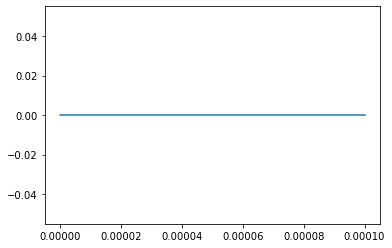

In [180]:
#Grafico m(t)
t = np.linspace(0, 100e-6, 1000)
plt.plot(t, m(t));

### Sistema de ecuaciones diferenciales

In [181]:
#Defino el sistema de ecuaciones de primer orden

def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]
    #Defino los términos de la ecuación diferencial de R(t). Genéricamente coloco como inputs mp, mpp, R y v_R aunque no haya tal dependencia
    #Los términos se encuentran definidos en mi cuadernillo

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Expreso dydt_1 = d(v_R/dt) = d2(R)/dt2 
    term1 = -(3/2)*v_R**2*(1 - v_R/(3*c_L) + 2*mp(t)/(3*c_L*rho_L_i))
    term2 = (1/rho_L_i)*(1 + v_R/c_L)*(p_B(R) - p_inf)
    term3 = (mpp(t)*R/rho_L_i)*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))
    term4 = (mp(t)/rho_L_i)*(v_R - mp(t)/(2*rho_L_i) + mp(t)*v_R/(2*c_L*rho_L_i))
    term5 = (R/c_L*rho_L_inf)*dpBdt(R)

    dydt_1 = (1/(R*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))     ))*(term1 + term2 + term3 + term4 + term5)

    return [dydt_0, dydt_1]


### Solución numérica

In [182]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 70e-9 #70 ns
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff


In [183]:
#Imprimo propiedades de la solución
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 4454
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 8.21171950e-23, 9.03289145e-22, 9.11500865e-21,
       9.12322037e-20, 6.49568517e-19, 4.97898407e-18, 2.05022266e-17,
       6.79829907e-17, 2.07668025e-16, 1.60451836e-15, 1.02081234e-14,
       7.81169521e-14, 4.13607728e-13, 8.10292277e-13, 1.21208418e-12,
       1.61007789e-12, 2.00416940e-12, 2.39516379e-12, 2.70234233e-12,
       3.00952088e-12, 3.51178711e-12, 3.94788588e-12, 4.38398465e-12,
       4.79244108e-12, 5.19410816e-12, 5.61030241e-12, 6.07680177e-12,
       6.43434598e-12, 6.69428636e-12, 6.95422674e-12, 7.33200271e-12,
       7.75328578e-12, 8.22660834e-12, 8.78041090e-12, 9.51959451e-12,
       1.02029465e-11, 1.08862985e-11, 1.15608372e-11, 1.22480790e-11,
       1.29608633e-11, 1.37073014e-11, 1.44934736e-11, 1.53238692e-11,
       1.62006423e-11, 1.71206488e-11, 

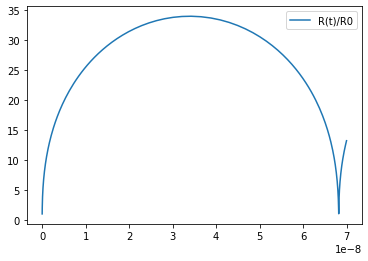

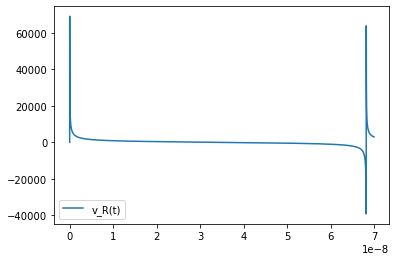

C:\Users\lupam\AppData\Local\Temp\ipykernel_9164\618697701.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return rho_Bunkin*u0**2*(1 + 2*mu)*(R0/R)**4


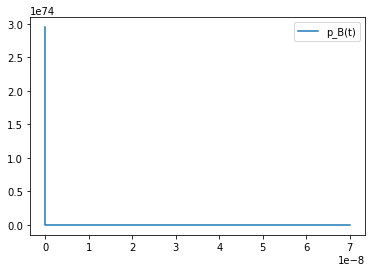

In [184]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, p_B(sol.t), label = "p_B(t)")
plt.legend()
plt.show()


### Verificación

Según el paper de Bunkin, a t = t_coal debe ocurrir que R = R1, ambos parámetros bien definidos
Supongamos por lo pronto que m = 0 para todo tiempo, asumiendo que la masa de los electrones entrantes, que son los responsables de la expansión inicial, es despreciable

In [185]:
a_i = 2e-5 #radio de Debye de un ion electrolito en un líquido. En este caso el agua (valor sacado del Bunkin) en [cm]
t_coal = ( 2/5*(R0/u0) )/np.sqrt(2*(1 + 2*mu))*(a_i/R0)**(5/2) #tiempo de coalescencia en [s] (creo)
l = 2*a_i #aproximación hecha en el Bunkin*
R1 = l/2 #radio del bubston necesario para que las burbujas se toquen

print("tiempo de coalescencia (t_coal): ", t_coal)
print("radio relativo teórico del bubston en t = t_coal (R1/R0): ", R1/R0)

tiempo de coalescencia (t_coal):  4.584739171374519e-09
radio relativo teórico del bubston en t = t_coal (R1/R0):  20.000000000000004


In [189]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = t_coal
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff

print("radio numérico del bubston en t = t_coal (R1): ", sol.y[0][-1]/R0)
#Sin masa: 19.185427198440635
#Con masa: 19.185427198440635
#NO HAY CAMBIO!

radio numérico del bubston en t = t_coal (R1):  19.185427198440635
